# Alto saxophone

* Sample duration = 5s
* model = ANN
* target = Alto

Distinguish between samples with alto saxophone from those without alto saxophone. Other brass and (most) woodwind instruments excluded.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.metrics import AUC, Recall
from keras.losses import Hinge

from pickles_to_pandas import pickles_to_pandas

In [4]:
NUM_LABEL_COLS = 13
NUM_COMPONENTS = 28
TEST_SIZE = 0.20
RANDOM_STATE = 0

In [5]:
df = pickles_to_pandas('./data/5s/labeled/features_r02')

In [6]:
df_filtered = df[df['excl'] == '0']  # exclude records we want to exclude
df_filtered.shape

(5411, 10790)

In [7]:
# exclude records we want to exclude
df_filtered = df_filtered[df_filtered['tenr'] == '0']  
df_filtered = df_filtered[df_filtered['sop'] == '0']
df_filtered = df_filtered[df_filtered['bari'] == '0']
df_filtered = df_filtered[df_filtered['clrt'] == '0']
df_filtered = df_filtered[df_filtered['tora'] == '0']
df_filtered = df_filtered[df_filtered['othr'] == '0']
df_filtered = df_filtered[df_filtered['trmp'] == '0']
df_filtered = df_filtered[df_filtered['trmb'] == '0']
df_filtered = df_filtered[df_filtered['otrb'] == '0']

num_x_cols = df_filtered.shape[1] - NUM_LABEL_COLS - 1  
# ^ last bit to adjust for zero indexing
data = df_filtered.iloc[:, 1:num_x_cols].to_numpy() 
# ^ these are the features
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

target = df_filtered[['alto']].to_numpy().ravel()  
# ^ this is the label

print(data.shape)
print(target.shape)

(2603, 10775)
(2603,)


### Use PCA to reduce number of features

In [8]:
pca = PCA(n_components=NUM_COMPONENTS)
pca.fit(data)
d = pca.transform(data)

### Generate train, test and validation sets

In [9]:
x_train, x_test, y_train, y_test = \
     train_test_split(d, target, 
                      test_size=TEST_SIZE, 
                      random_state=RANDOM_STATE)
print(y_train.shape)
print(y_test.shape)
split_index = y_test.shape[0] // 2
print(split_index)
x_validate = x_test[0:split_index]
y_validate = y_test[0:split_index]
x_test = x_test[split_index:]
y_test = y_test[split_index:]
print(x_train.shape)
print(x_validate.shape)
print(x_test.shape)

(2082,)
(521,)
260
(2082, 28)
(260, 28)
(261, 28)


### Define ANN model

In [9]:
model = Sequential()
model.add(Dense(64, activation='relu'))
# https://keras.io/api/layers/regularization_layers/dropout/
model.add(Dropout(0.1))  #  input_shape=(2,)
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [10]:
# See: https://keras.io/api/metrics/classification_metrics
# AUC(name='auc'), 
model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=[Recall(name='recall')])

### Train

In [11]:
history = model.fit(x_train, y_train, epochs=50, batch_size=10, 
                    validation_data=(x_validate, y_validate))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 2082 samples, validate on 260 samples
Epoch 1/50
2082/2082 [==============================] - 1s 388us/step - loss: 1.1626 - recall: 0.5417 - val_loss: 0.4332 - val_recall: 0.6308
Epoch 2/50
2082/2082 [==============================] - 0s 194us/step - loss: 0.5463 - recall: 0.6232 - val_loss: 0.3729 - val_recall: 0.6923
Epoch 3/50
2082/2082 [==============================] - 0s 192us/step - loss: 0.4126 - recall: 0.6884 - val_loss: 0.3165 - val_recall: 0.6308
Epoch 4/50
2082/2082 [==============================] - 0s 196us/step - loss: 0.3408 - recall: 0.7228 - val_loss: 0.2882 - val_recall: 0.7077
Epoch 5/50
2082/2082 [==============================] - 0s 191us/step - loss: 0.3193 - recall: 0.7011 - val_loss: 0.2898 - val_recall: 0.7077
Epoch 6/50
2082/2082 [==============================] - 0s 194us/step - loss: 0.2911 - recall: 0.7409 - val_loss: 0.2839 - val_recall: 0.7846
Epoch 

In [12]:
# auc, 
loss, recall = model.evaluate(x_test, y_test)
# print('AUC: %.2f' % (auc * 100))
print('Recall: %.2f' % (recall * 100))

261/261 [==============================] - 0s 85us/step
Recall: 82.86


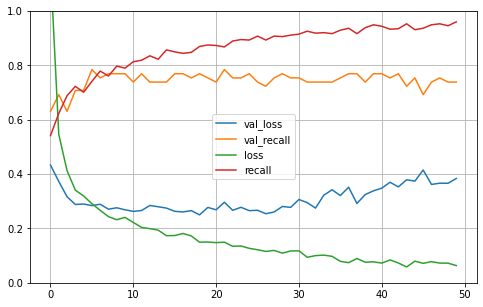

In [13]:
# history is a keras.callbacks.callbacks.History object
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


In [14]:
# See: https://keras.io/api/metrics/classification_metrics
# AUC(name='auc'), 
model.compile(loss='hinge', optimizer='adam', 
              metrics=[Recall(name='recall')])

In [15]:
history = model.fit(x_train, y_train, epochs=50, batch_size=10, 
                    validation_data=(x_validate, y_validate))

Train on 2082 samples, validate on 260 samples
Epoch 1/50
2082/2082 [==============================] - 1s 450us/step - loss: 0.7781 - recall: 0.9402 - val_loss: 0.8534 - val_recall: 0.7231
Epoch 2/50
2082/2082 [==============================] - 0s 234us/step - loss: 0.7764 - recall: 0.9348 - val_loss: 0.8530 - val_recall: 0.7385
Epoch 3/50
2082/2082 [==============================] - 0s 229us/step - loss: 0.7682 - recall: 0.9384 - val_loss: 0.8487 - val_recall: 0.7231
Epoch 4/50
2082/2082 [==============================] - 0s 224us/step - loss: 0.7716 - recall: 0.9348 - val_loss: 0.8539 - val_recall: 0.7385
Epoch 5/50
2082/2082 [==============================] - 1s 250us/step - loss: 0.7721 - recall: 0.9366 - val_loss: 0.8547 - val_recall: 0.7385
Epoch 6/50
2082/2082 [==============================] - 0s 238us/step - loss: 0.7677 - recall: 0.9547 - val_loss: 0.8603 - val_recall: 0.7385
Epoch 7/50
2082/2082 [==============================] - 0s 218us/step - loss: 0.7654 - recall: 0.9547

In [16]:
# auc, 
loss, recall = model.evaluate(x_test, y_test)
# print('AUC: %.2f' % (auc * 100))
print('Recall: %.2f' % (recall * 100))

261/261 [==============================] - 0s 61us/step
Recall: 81.43


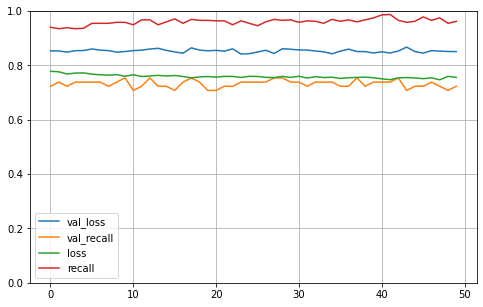

In [17]:
# history is a keras.callbacks.callbacks.History object
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


## Try different sized layers

In [11]:
model = Sequential()
model.add(Dense(32, activation='relu'))
# https://keras.io/api/layers/regularization_layers/dropout/
model.add(Dropout(0.1))  #  input_shape=(2,)
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [12]:
# See: https://keras.io/api/metrics/classification_metrics
# AUC(name='auc'), 
model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=[Recall(name='recall')])

In [13]:
history = model.fit(x_train, y_train, epochs=50, batch_size=10, 
                    validation_data=(x_validate, y_validate))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 2082 samples, validate on 260 samples
Epoch 1/50
2082/2082 [==============================] - 1s 412us/step - loss: 0.9329 - recall: 0.5217 - val_loss: 0.5989 - val_recall: 0.5077
Epoch 2/50
2082/2082 [==============================] - 1s 248us/step - loss: 0.5254 - recall: 0.5725 - val_loss: 0.4346 - val_recall: 0.5846
Epoch 3/50
2082/2082 [==============================] - 1s 308us/step - loss: 0.4356 - recall: 0.6377 - val_loss: 0.3691 - val_recall: 0.6154
Epoch 4/50
2082/2082 [==============================] - 1s 323us/step - loss: 0.3863 - recall: 0.6486 - val_loss: 0.3387 - val_recall: 0.6154
Epoch 5/50
2082/2082 [==============================] - 1s 300us/step - loss: 0.3604 - recall: 0.6413 - val_loss: 0.3159 - val_recall: 0.5692
Epoch 6/50
2082/2082 [==============================] - 0s 221us/step - loss: 0.3333 - recall: 0.6902 - val_loss: 0.2917 - val_recall: 0.6154
Epoch 

In [14]:
# auc, 
loss, recall = model.evaluate(x_test, y_test)
# print('AUC: %.2f' % (auc * 100))
print('Recall: %.2f' % (recall * 100))

261/261 [==============================] - 0s 70us/step
Recall: 85.71


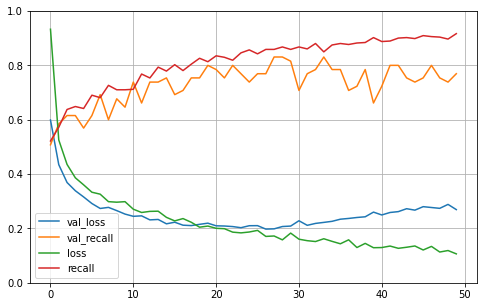

In [15]:
# history is a keras.callbacks.callbacks.History object
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


In [21]:
model = Sequential()
model.add(Dense(24, activation='relu'))
# https://keras.io/api/layers/regularization_layers/dropout/
model.add(Dropout(0.1))  #  input_shape=(2,)
model.add(Dense(12, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [22]:
# See: https://keras.io/api/metrics/classification_metrics
# AUC(name='auc'), 
model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=[Recall(name='recall')])

In [23]:
history = model.fit(x_train, y_train, epochs=50, batch_size=10, 
                    validation_data=(x_validate, y_validate))

Train on 2082 samples, validate on 260 samples
Epoch 1/50
2082/2082 [==============================] - 1s 437us/step - loss: 1.4058 - recall: 0.4058 - val_loss: 0.8534 - val_recall: 0.4615
Epoch 2/50
2082/2082 [==============================] - 1s 275us/step - loss: 0.6904 - recall: 0.5072 - val_loss: 0.5993 - val_recall: 0.5385
Epoch 3/50
2082/2082 [==============================] - 1s 263us/step - loss: 0.5366 - recall: 0.5562 - val_loss: 0.4776 - val_recall: 0.5077
Epoch 4/50
2082/2082 [==============================] - 0s 207us/step - loss: 0.4665 - recall: 0.5978 - val_loss: 0.4310 - val_recall: 0.5538
Epoch 5/50
2082/2082 [==============================] - 0s 222us/step - loss: 0.4109 - recall: 0.6304 - val_loss: 0.3877 - val_recall: 0.6154
Epoch 6/50
2082/2082 [==============================] - 0s 221us/step - loss: 0.3744 - recall: 0.6449 - val_loss: 0.3584 - val_recall: 0.5846
Epoch 7/50
2082/2082 [==============================] - 0s 216us/step - loss: 0.3638 - recall: 0.6576

In [24]:
# auc, 
loss, recall = model.evaluate(x_test, y_test)
# print('AUC: %.2f' % (auc * 100))
print('Recall: %.2f' % (recall * 100))

261/261 [==============================] - 0s 192us/step
Recall: 68.57


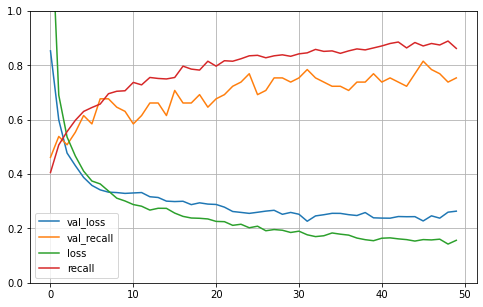

In [25]:
# history is a keras.callbacks.callbacks.History object
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Try different activation functions

In [16]:
model = Sequential()
model.add(Dense(32, activation='tanh'))
# https://keras.io/api/layers/regularization_layers/dropout/
model.add(Dropout(0.1))  #  input_shape=(2,)
model.add(Dense(16, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

In [17]:
# See: https://keras.io/api/metrics/classification_metrics
# AUC(name='auc'), 
model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=[Recall(name='recall')])

In [18]:
history = model.fit(x_train, y_train, epochs=50, batch_size=10, 
                    validation_data=(x_validate, y_validate))

Train on 2082 samples, validate on 260 samples
Epoch 1/50
2082/2082 [==============================] - 1s 448us/step - loss: 0.6124 - recall: 0.5181 - val_loss: 0.5007 - val_recall: 0.5385
Epoch 2/50
2082/2082 [==============================] - 1s 310us/step - loss: 0.4630 - recall: 0.5054 - val_loss: 0.3908 - val_recall: 0.6000
Epoch 3/50
2082/2082 [==============================] - 1s 306us/step - loss: 0.4006 - recall: 0.5761 - val_loss: 0.3587 - val_recall: 0.6615
Epoch 4/50
2082/2082 [==============================] - 1s 367us/step - loss: 0.3669 - recall: 0.5978 - val_loss: 0.3369 - val_recall: 0.6615
Epoch 5/50
2082/2082 [==============================] - 1s 315us/step - loss: 0.3436 - recall: 0.6377 - val_loss: 0.3352 - val_recall: 0.6769
Epoch 6/50
2082/2082 [==============================] - 1s 275us/step - loss: 0.3264 - recall: 0.6576 - val_loss: 0.3242 - val_recall: 0.6615
Epoch 7/50
2082/2082 [==============================] - 1s 241us/step - loss: 0.3016 - recall: 0.6902

In [19]:
# auc, 
loss, recall = model.evaluate(x_test, y_test)
# print('AUC: %.2f' % (auc * 100))
print('Recall: %.2f' % (recall * 100))

261/261 [==============================] - 0s 71us/step
Recall: 70.00


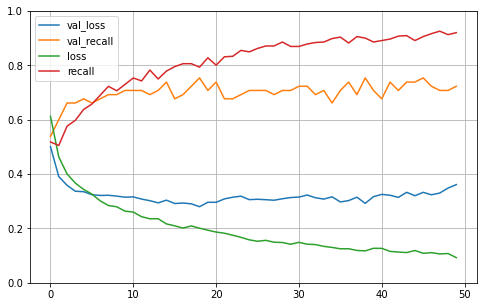

In [20]:
# history is a keras.callbacks.callbacks.History object
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()